# Gumbel Softmax: Enabling Differentiable Categorical Sampling

#### Prereq
A prereq to this is you are already familiar with VAEs and VQ-VAEs, you can see my tutorial on that [here](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Vector_Quantized_Variational_AutoEncoders.ipynb)!

#### Recap VQVAE

Think back to our VQ-VAE setup. Our encoder takes data and compresses it down to a vector. We then compare this vector to a set of codes in our codebook and copy over whatever is closest. The decoder then gets these quantized codes to do its reconstruction task. What was the problem though? That entire $argmin$ operation is **NOT DIFFERENTIABLE**. So to train this model, we had to employ some tricks. 

1. Straight through gradient to copy our gradient information around the argmin
2. Codebook Loss to force codes to be close to encoder outputs
3. Commitment Loss to force encoder outputs to move towards the codes

#### Recap Reparameterization Trick


#### Reformulate the Problem as Sampling

Lets think about this problem a little differently then. If our codebook has $K$ codes, our goal is to map our encoder output to one of these codes, and in VQ-VAE we select the code that has the smallest distance from the encoder output.

But, what if instead, we project our encoder output dimenion to $K$, compute the softmax over them and select the code with the highest probability? It's kind of like classification, we are trying to classify, for this specific encoder output, which of the $K$ codes is best! The problem though with this setup is again, the quantized codes will be passed on to the decoder, bur our selection of the best code is still an $argmax$ of the highest probability code. 

This is exactly what Gumbel-Softmax fixes. It allows for discrete sampling in a differentiable way! But before we go any deeper into this, we need to first explore and prove the Gumbel-Max trick. I will be following [this derivation](https://lips.cs.princeton.edu/the-gumbel-max-trick-for-discrete-distributions/) from the Princeton CS group, but fill in all the mathematical details they omitted!

## Gumbel-Max Trick

Before we explore Gumbel-Softmax, we need to understand Gumbel-Max! It sounds fancy but it isn't. Something we have to do all the time is sample from a distribution. For example in LLMs, our goal is next token prediction. The way we typically do this is we create a probability vector over all the things that next token can be and then select a token based on that distribution. There are lots of ways to select this, 

1. Greedy Decoding: Select the token with the highest probability
2. Multinomial Sampling: Randomly sample a token with the computed distribution

Multinomial sampling is a very popular method but is a little slow because we have to do the following:
1. Get our raw logits from the model
2. Compute softmax over all the logits
3. Multionomial sample given that probability vector

We don't really care about the probability vector though. We just want to sample a single token from our categorical distribution. The Gumbel-Max trick is a reparamterization of this whole setup, and is the backbone for the more important Gumbel-Softmax we will get to later!

## What is the Gumbel Distribution?

I have said Gumbel a bunch, so lets define it now! This is a distribution (also known as Type-1 Generalized Extreme Value Distribution) that is used to model the maximums (or minimums). 

The CDF of the distribution is as follows:

$$F(x) = G(\mu, \beta) \sim \exp(-\exp(\frac{x-\mu}{\beta}))$$

$\mu$ is our parameter for the Mode of the distribution and $\beta$ is our scale parameter. Our standard Gumbel distribution will be $G(0,1)$, so it looks like:

$$F(x) = G(\mu, \beta) \sim \exp(-\exp(x))$$

We can easily get our PDF from here by just taking the derivative:

$$f(x) = F'(x) = e^{-e^{-x}}*(-e^{-x})*(-1) = e^{-x}e^{-e^{-x}}$$

### Applications of Gumbel Distribution

This is pretty popular for environmental science. For example, lets say you have a dataset of temperature every day. It is pretty likely that the temperature of a day is close to normally distributed:

$$T \sim N(\mu, \sigma)$$

And of course we have a dataset of these temperatures from every day:

$$[T_1, T_2, T_3, ..., T_N]$$

So the question I ask is: What is the distribution of:

$$\max(T_1, T_2, T_3, ..., T_N)$$

Each sample comes from a normal distribution, but we want to model the max over many samples. This is exactly what the Gumbel Distribution is modeling!



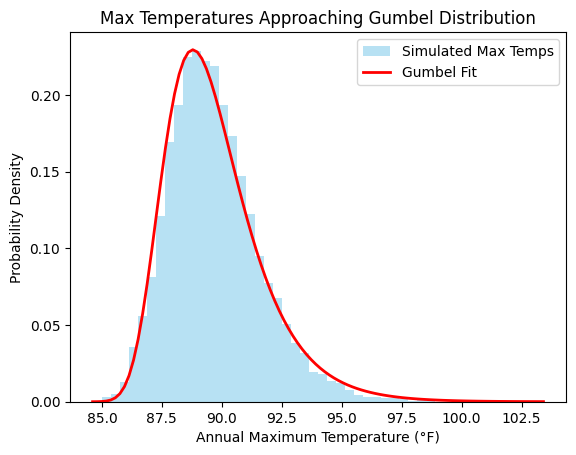

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r, norm

mu_temp = 75      
sigma_temp = 5    
days_per_year = 365
years = 10000     

### Simulate daily temperatures For Every Year ###
daily_temps = np.random.normal(mu_temp, sigma_temp, size=(years, days_per_year))

### Take the maximum temperature each year ###
annual_max = daily_temps.max(axis=1)

### Fit a Gumbel distribution to the maxima ###
params = gumbel_r.fit(annual_max)

# Plot histogram and Gumbel fit
x = np.linspace(min(annual_max), max(annual_max), 100)
plt.hist(annual_max, bins=50, density=True, alpha=0.6, color='skyblue', label="Simulated Max Temps")
plt.plot(x, gumbel_r.pdf(x, *params), 'r-', lw=2, label="Gumbel Fit")
plt.xlabel("Annual Maximum Temperature (°F)")
plt.ylabel("Probability Density")
plt.title("Max Temperatures Approaching Gumbel Distribution")
plt.legend()
plt.show()


So if we can use Gumbel Distributions to model the Max of something, it kind of makes sense that we can use it to model our $argmax$ as well! The Gumbel Max trick takes advantage of exactly this! Here is the setup for the Gumbel Max trick:

If we have some logit outputs from our neural network, add some standard gumbel noise to it and take the argmax, this should be equivalent to having taken the softmax of the logits and then sample from a multinomial distribution. 

## Gumbel-Max Trick Proof

Show that Gumbel-Max trick is equivalent to sampling from probabilities generated via softmax. 

Let our raw outputs from the neural network be denoted as $o_i$

$$\text{if } Y = \underset{i}{\operatorname{argmax}}\{o_i + g_i\}$$
$$\text{where }g_i \sim G(0,1)$$
$$\text{Show that }P(Y=i) = \frac{e^{o_i}}{\sum_j{e^{o_j}}}$$

#### Gumbel Shift Property

Like Normal distributions, if we add something to a Gumbel Distribution it just shift our $\mu$ parameter. So if we have:

$$x\sim G(0,1)$$

and we add a constant to $x$ we will get:

$$x+c \sim G(c,1)$$

So lets use that to our advantages and star tthe setup for the problem, if we are adding randomly sampled gumbel noise $g_i$ to our logit $o_i$ we can then write that the distribution is:

$$o_i + g_i \sim G(o_i, 1)$$

Lets write that $z_i = o_i + g_i$. What is then the CDF of $z_i$?

$$P(z_i<z) = P(o_i + g_i < z) = P(g_i < z - o_i) = F(z-o_i)$$

Where F is the CDF of the gumbel distribution. 

#### Step 1: Express P(Y=k)

If we say that $y=k$, that implies that $Z_k > Z_j \forall j\neq k$. This means that if $z_k$ is equal to some $z$, all $z_j$ must be less than $z$. 

So we can break this up, the probability of $z_k=z$ is our PDF and can be written as $f(z-o_k)$ and for all other $z_j$ where $j \neq k$ it must be les than $z$, so $z_j < z$ is a CDF and can be written as $F(z-o_j)$.

Each $z_i$ is iid so the overall probability is the product of all the events, where $z_k=z$ and $z_j<z$ for all $j \neq k$. This is possible for any value of $z$, so we sum (integrate) over all possibilites of $z$.

$$P(y=k) = \int_{-\infty}^{\infty}f(z-o_k)\prod_{j\neq k}F(z-o_j)dz$$

Lets grab our formulations for $f(z-o_k)$ and $F(z-o_j)$:

$$f(z-o_k) = e^{-(z-o_k)}e^{-e^{z-o_k}}$$
$$\prod_{j\neq k}F(z-o_j) = e^{-\sum_{j \neq k}e^{-(z-o_j)}}$$

So all together we get:

$$P(y=k) = \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-e^{z-o_k}}e^{-\sum_{j \neq k}e^{-(z-o_j)}}dz$$
$$= \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-(e^{z-o_k} + \sum_{j \neq k}e^{-(z-o_j)})}dz$$
$$= \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-\sum_{j}e^{-(z-o_j)}}dz$$

For simplicy, let $s(z) = \sum_{j}e^{-(z-o_j)}$

So we finally have:
$$= \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-s(z)}dz$$

Its time to integrate! Lets do a quick variable substitution:

$$u = z - o_k \implies z = u + o_k$$
$$dz = du$$
$$z \rightarrow \infty, u \rightarrow \infty$$
$$z \rightarrow -\infty, u \rightarrow -\infty$$

So doing this substituion we get:

$$= \int_{-\infty}^{\infty}e^{-u}e^{-s(u+o_k)}du$$

Lets take a look at $s(u+o_k)$. 

If
$$s(z) = \sum_{j}e^{-(z-o_j)}$$ 

then 

$$s(u+o_k) = \sum_{j}e^{-(u+o_k-o_j)}$$
$$= \sum_{j}e^{-u}e^{o_j-o_k}$$
$$= e^{-u}\sum_{j}e^{o_j-o_k}$$

Again, for simplicty let: 
$$t = \sum_{j}e^{o_j-o_k} = \frac{\sum_{j}e^{o_j}}{o_k}$$

Hmmm, thats starting to look like a softmax! Exciting!

So we can now write:

$$s(u+o_k) = e^{-u}t$$

So using our new variable t, lets just rewrite our integral

$$= \int_{-\infty}^{\infty}e^{-u}e^{-e^{-u}t}du$$

One more variable substitution!

$$v = e^{-u} \implies u = -log(v)$$
$$du = -\frac{dv}{v}$$
$$u \rightarrow \infty, v \rightarrow 0$$
$$u \rightarrow -\infty, v \rightarrow \infty$$

$$= \int_{\infty}^{0}-ve^{-tv}\frac{dv}{v}$$
$$= \int_{\infty}^{0}-e^{-tv}dv$$
$$= \int_{0}^{\infty}e^{-tv}dv$$
$$= -\frac{1}{t}\left[e^{-tv}\right]_0^{\infty}$$
$$= -\frac{1}{t}(0 - 1)$$
$$= \frac{1}{t}$$

and we know that:

$$t = \sum_{j}e^{o_j-o_k} = \frac{\sum_{j}e^{o_j}}{o_k}$$

Therefore our final result is:
$$P(y=k) = \frac{o_k}{\sum_{j}e^{o_j}}$$

That looks like softmax to me! So we have shown that adding standard gumbel noise to our logits and doing an argmax is equivalent to have taken a softmax and randomly sampled with that distribution! 

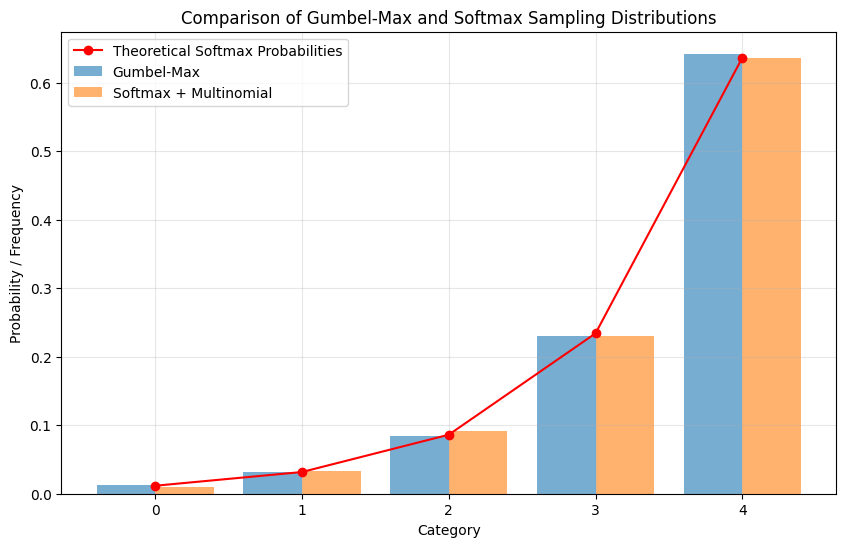

In [2]:
import torch
import matplotlib.pyplot as plt

# Define logits for a categorical distribution with 5 categories
logits = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# Number of samples to generate
num_samples = 10000

# Function to sample using Gumbel-Max trick
def gumbel_max_sample(logits, num_samples):
    # Generate Gumbel noise: -log(-log(U)), U ~ Uniform(0,1)
    uniform = torch.rand(num_samples, len(logits))
    gumbel = -torch.log(-torch.log(uniform + 1e-20))  # Add 1e-20 to avoid log(0)
    # Add noise to logits and take argmax
    perturbed_logits = logits + gumbel
    samples = torch.argmax(perturbed_logits, dim=1)
    return samples

# Function to sample using softmax + multinomial
def softmax_sample(logits, num_samples):
    # Compute softmax probabilities
    probs = torch.softmax(logits, dim=0)
    # Sample from categorical distribution
    samples = torch.multinomial(probs, num_samples, replacement=True)
    return samples

# Generate samples
gumbel_samples = gumbel_max_sample(logits, num_samples)
softmax_samples = softmax_sample(logits, num_samples)

# Compute empirical frequencies
gumbel_counts = torch.bincount(gumbel_samples, minlength=len(logits)) / num_samples
softmax_counts = torch.bincount(softmax_samples, minlength=len(logits)) / num_samples

# Compute theoretical softmax probabilities
probs = torch.softmax(logits, dim=0)

# Plotting
categories = torch.arange(len(logits))
plt.figure(figsize=(10, 6))
plt.bar(categories - 0.2, gumbel_counts, width=0.4, label='Gumbel-Max', alpha=0.6)
plt.bar(categories + 0.2, softmax_counts, width=0.4, label='Softmax + Multinomial', alpha=0.6)
plt.plot(categories, probs, 'ro-', label='Theoretical Softmax Probabilities')
plt.xlabel('Category')
plt.ylabel('Probability / Frequency')
plt.title('Comparison of Gumbel-Max and Softmax Sampling Distributions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('gumbel_max_comparison.png')
plt.show()